### MLGeo23 Petro Pixel Poppers Project documentation

Please see the [root](./ESS469_Project_ML.ipynb) document for navigation.


# Data exploration


Here we:

1. Open datasets from the HDF5 database into a dict of `pd.Dataframes`
2. Select informative minerals and elements to work with
3. Describe the data
4. Explore histograms of the data
5. Attempt other visualizations

For future consideration: extract additional spatial features to characterize the spatial distribution of grains in different thin sections and include spatial recognition in models.


## 0. Packages


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker
import os
import tables as tt
# for navigation
import pandas as pd

# for file creation
import h5py
# open .tifs
from PIL import Image
from tifffile import imread

%matplotlib inline

### 1. Opening HDF5 datasets in Pandas

Pandas has a built-in function for this purpose:
`pandas.read_hdf(filepath, key=groupname_string, mode='r')`

We'll load all of the minerals' maps into a dict of mineral:array value pairs, plus indices and coordinates.


In [2]:

filepath = './Aikin_Data/78.7-10-1_Hot_data.h5'
groupname = 'masked_maps'
with h5py.File(filepath, 'r') as datafile:
    print(datafile.keys())
    group = datafile[groupname]
 
    dset_names = list(group.keys())
    dset_values = list(group.values())
    print(dset_names)
    print(dset_values)
    # create a dict for the pandas dataframes
masked_maps = {}
for mineralMap in dset_names:
    dataset_path = f"{groupname}/{mineralMap}"
    df = pd.read_hdf(filepath, key=dataset_path, mode='r')
    masked_maps[mineralMap] = df

mineralKeys = list(masked_maps.keys())
print(mineralKeys)
print('This is the masked dataset for', mineralKeys[3])
masked_maps[mineralKeys[3]].head()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './Aikin_Data/78.7-10-1_Hot_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### 2. Select informative minerals and elements to work with


Not as useful: cerium, yttrium, zirconium, (poss. Ti)

note: base phases to show on chem. formulas of minerals

major Mg, Fe minerals:
#Garnet, Biotite
major K, AL phases
muscovite

#Garnet, muscovite, biotite, albite (plag), quartz

Chemical formulas

1. Albite: $\mathrm{NaAlSi} i_3 \mathrm{O}_8$

2. Biotite: $K(F e, M g)_3 \mathrm{AlSi}_3 \mathrm{O}_{10}(\mathrm{OH})_2$

3. Garnet: $(\mathrm{Fe}, \mathrm{Mg})_3 \mathrm{Al}_2\left(\mathrm{SiO}_4\right)_3$

4. Kspar: $\mathrm{KAlSi} i_3 \mathrm{O}_8$

5. Muscovite: $K A l_2\left(A l S i_3 O_{10}\right)(O H)_2$

6. Quartz: $\mathrm{SiO}_2$

7. Sericite: $(K, H) A l_2(S i, A l)_4 O_{10}(O H)_2$

| Mineral Name     | Mineral Formula                        | Mapped elements   |
| ---------------- | -------------------------------------- | ----------------- |
| Albite Maps\*    | \(NaAlSi_3O_8\)                        | Al, Si            |
| Biotite Maps\*   | \(K(Fe, Mg)_3AlSi_3O_{10}(OH)\_2\)     | Al, Fe, K, Mg, Si |
| Garnet Maps\*    | \((Fe, Mg)\_3Al_2(SiO_4)\_3\)          | Al, Fe, Mg, Si    |
| Kspar Maps       | \(KAlSi_3O_8\)                         | Al, K, Si         |
| Muscovite Maps\* | \(KAl*2(AlSi_3O*{10})(OH)\_2\)         | Al, K, Si         |
| Quartz Maps\*    | \(SiO_2\)                              | Si                |
| Sericite Maps    | \((K, H)Al*2(Si, Al)\_4O*{10}(OH)\_2\) | Al, K, Si         |

Primary elements: (do these show up in PCA?)
Fe, Al, Mg, K, Si, (Ca). Ti may also be of interest.


There are some negative values. Let's get rid of those.
**Future work**: investigate the cause of the negative numbers and account for them in the data accordingly.


Let's select only the minerals and elements of interest.


In [3]:
# figure out which elements to remove
indices_to_remove = [0, 1, 4, 10, 11]

# get the series names
seriesNames = masked_maps[mineralKeys[0]].keys()

# remove the unwanted elements and labels, coords
elementNames = [item for i, item in enumerate(seriesNames) if i not in indices_to_remove]


# figure out which minerals to remove
indices_to_remove = [3,6]

# remove the rest
mineralMaps =  [item for i, item in enumerate(mineralKeys) if i not in indices_to_remove]
print(mineralKeys)
# clean the mineral names
mineralNames = []
for k in range(len(mineralMaps)):
    mineralName = str(mineralMaps[k])[:-5]
    mineralNames.append(mineralName)
print(elementNames)
print(mineralMaps)


['albite_maps', 'biotite_maps', 'garnet_maps', 'kspar_maps', 'muscovite_maps', 'quartz_maps', 'sericite_maps']
['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si', 'Ti']
['albite_maps', 'biotite_maps', 'garnet_maps', 'muscovite_maps', 'quartz_maps']


Accessing one mineral mask dataset at a time:


In [4]:
this_mineral = mineralMaps[2]
df = masked_maps[this_mineral]

#print(df.mineral_labels)
# see all unique values in a series
#sorted(df['mineral_labels'].unique().astype(int))
print('This is the masked data for ' + mineralKeys[-5][:-5])
df.head()

This is the masked data for garnet


,x_coords,y_coords,Al,Ca,Ce,Fe,K,Mg,Si,Ti,Y,Zr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
3,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's show one of the masked maps:


/var/folders/fn/12nsfndd1vv_l4h9f_nbs8c80000gn/T/ipykernel_10969/3805296564.py:16: RuntimeWarning: invalid value encountered in log
  log_map = np.log(element_map + 0.08)


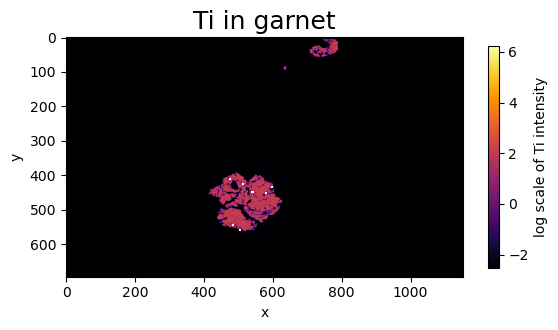

In [5]:
from matplotlib.colors import LogNorm
# choose the mineral
this_mineral = mineralMaps[2]
df = masked_maps[this_mineral]

# choose the element
selected_element = elementNames[-1]
this_series = df[selected_element]

# get the dimensions and reshape
x_dim = df['x_coords'].max().astype(int) + 1
y_dim = df['y_coords'].max().astype(int) + 1

element_array = this_series.to_numpy()
element_map = element_array.reshape(x_dim, y_dim)
log_map = np.log(element_map + 0.08)

plt.imshow(log_map, cmap='inferno')  # 'viridis', 'gs'
plt.colorbar(label='log scale of ' + selected_element + ' intensity', shrink =0.6)   # Add a colorbar to the plot for reference
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'{selected_element} in {this_mineral[:-5]}', size = 18)
plt.show()



Or many:


['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si', 'Ti']
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)


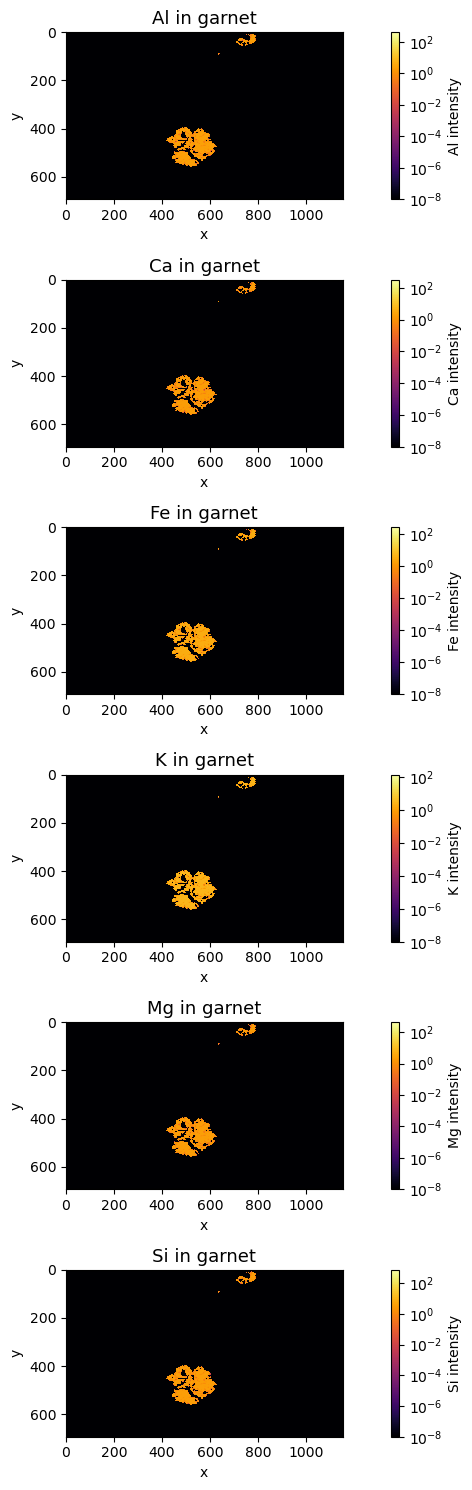

In [ ]:
# num_rows = len(mineralMaps)
# num_cols = len(elementNames)
# print(num_rows)
# print(num_cols)
rows = [0,1,2,3,4,5]
plot_elements = []
for i in rows:
    plot_elements.append(elementNames[i])

print(elementNames)
# Create a subplot grid
fig, axes = plt.subplots(6,1, figsize=(10, 15))

# Loop through each subplot
for i in range(1):
    for j in range(6):
        # # Choose the mineral
        # this_mineral = mineralMaps[i]
        # df = masked_maps[this_mineral]

        # Choose the element
        selected_element = plot_elements[j + i*2]
        this_series = df[selected_element]

        # Get the dimensions and reshape
        x_dim = df['x_coords'].max().astype(int) + 1
        y_dim = df['y_coords'].max().astype(int) + 1

        element_array = this_series.to_numpy()
        element_map = element_array.reshape(x_dim, y_dim)
        log_map = np.log(element_map + 0.001) # can't have zeros when taking log

        zoomed = log_map[(x_dim * 3//5).astype(int) : (x_dim * 2//3).astype(int), (y_dim * 3//5).astype(int) : (y_dim * 2//3).astype(int)]
        # Plot the colors using a log scale with 0 values set to black
        print(axes.shape)
        im = axes[j].imshow(log_map, cmap='inferno', norm=LogNorm(vmin=1e-8, vmax=element_array.max(), clip=True))  # 'viridis', inferno, plasma, etc.
        axes[j].set_title(f'{selected_element} in {this_mineral[:-5]}', size=13)
        axes[j].set_xlabel('x')
        axes[j].set_ylabel('y')
        fig.colorbar(im, ax=axes[j], label=selected_element + ' intensity', shrink=1)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### 3. Describe the data

#### Statistical analysis


In [ ]:
print('These statistical features describe the ' + this_mineral + 'mask')
df.describe()

These statistical features describe the garnet_mapsmask


,x_coords,y_coords,Al,Ca,Ce,Fe,K,Mg,Si,Ti,Y,Zr
count,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000,800640.000000
mean,347.000000,575.500000,7.384313,1.459508,0.214452,3.400675,1.875733,5.150303,10.648205,0.222970,0.882339,0.004193
std,200.629135,332.553833,46.131725,9.196415,1.446523,21.490746,11.973731,33.278801,66.535561,1.783450,6.305620,0.128567
min,0.000000,0.000000,0.000000,-0.000000,-1.262394,-0.000000,-0.000000,-0.000000,-0.000000,-0.934871,-0.000000,-0.316437
25%,173.000000,287.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,347.000000,575.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000
75%,521.000000,863.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,694.000000,1151.000000,415.154816,323.227051,133.737610,268.477081,130.567459,422.678589,752.447571,505.065125,1618.062500,20.683563


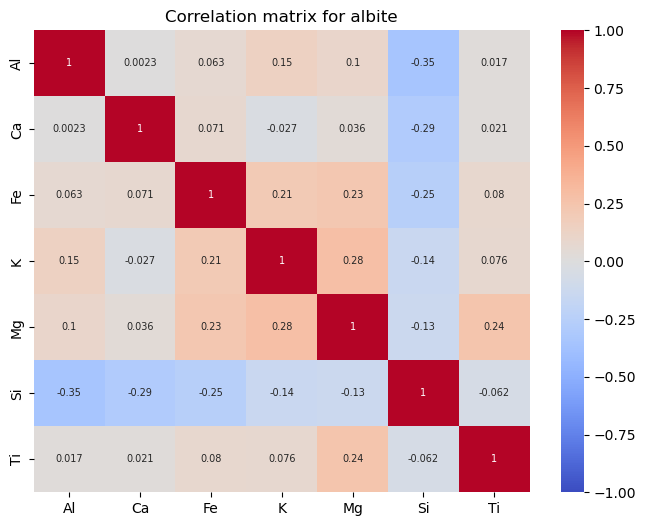

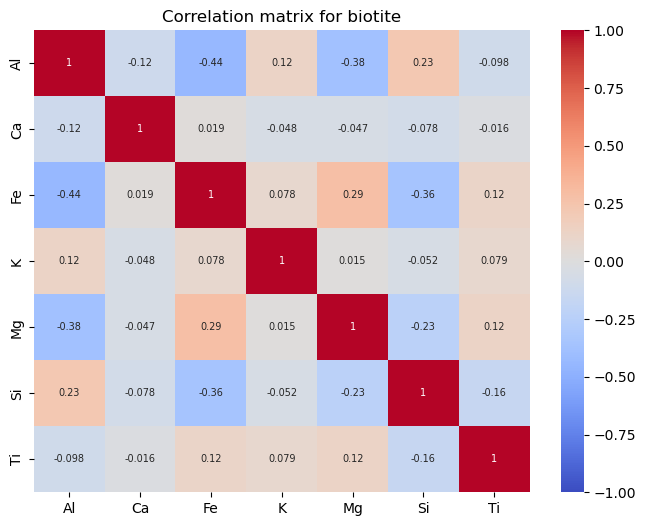

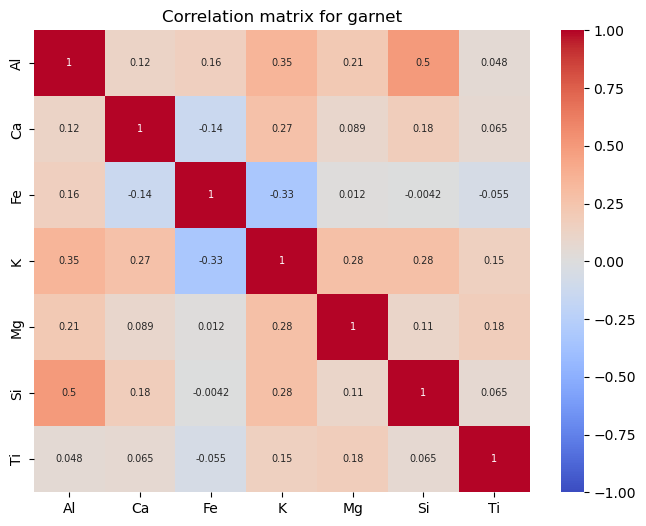

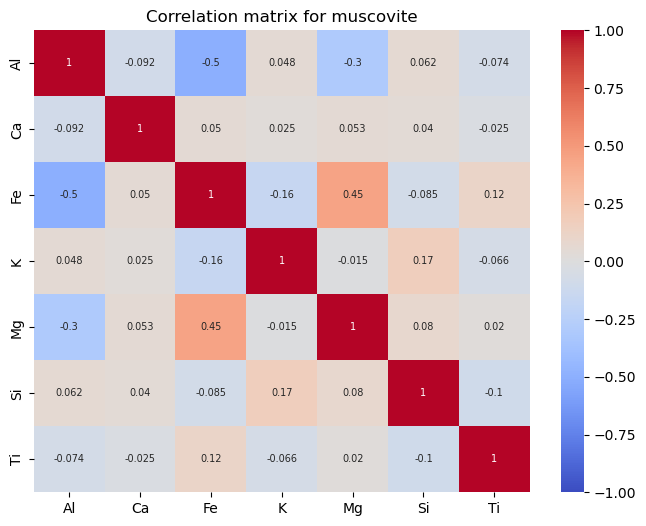

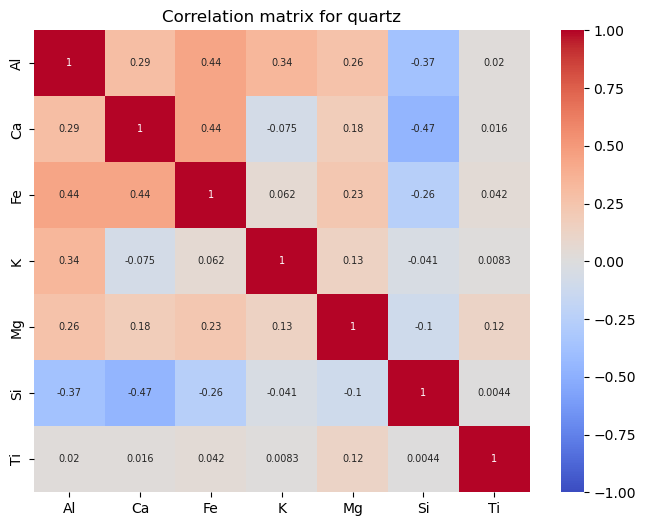

In [21]:
import seaborn as sns
for mineraldf in mineralMaps:
    this_df = masked_maps[mineraldf]
    selected_element_series = this_df.iloc[:,[2,3,5,6,7,8,9]]

    this_df_c = selected_element_series.map(lambda x: max(0, x))

    this_df_f = this_df_c[(this_df_c != 0).any(axis=1)]

    correlation_matrix = this_df_f.corr()
    
    # Plot the heatmap using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"size": 7, })
    plt.title('Correlation matrix for ' + mineraldf[:-5])
    # Show the plot
    plt.show()

In [5]:
masked_maps[mineralKeys[0]]

columns = df.keys()
x = df[columns[2]]
y = df[columns[3]]
z = df[columns[4]]
# plot the data
fig=plt.figure(figsize=(11,8))
ax=fig.add_subplot(projection='3d')
ax.scatter(x,y,z);ax.grid(True)

ax.set_xlabel(columns[2])
ax.set_ylabel(columns[3])
ax.set_zlabel(columns[4])
plt.tight_layout()
plt.show()

NameError: name 'masked_maps' is not defined

In [6]:
print(elementNames)

NameError: name 'elementNames' is not defined

### 4. Explore histograms of the data


In [ ]:
Using matplotlib .hist:

Total number of  garnet sample points:  20174
Total number of  garnet sample points:  20174
Total number of  garnet sample points:  20174
Total number of  garnet sample points:  20174
Total number of  garnet sample points:  20174
Total number of  garnet sample points:  20174
Total number of  garnet sample points:  20174


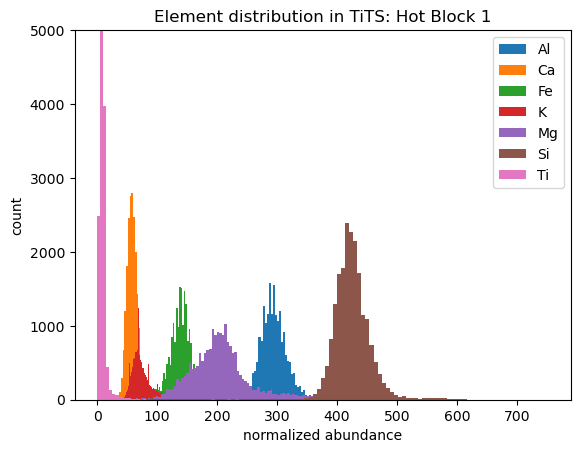

In [ ]:
this_mineral = mineralMaps[2]
df = masked_maps[this_mineral]
df_s = df[elementNames]

for element in elementNames:
    
    # make negatives 0
    df_c = df.map(lambda x: max(0, x))
    # remove the zeros
    df_f = df_c[(df_c[elementNames] != 0).any(axis=1)]

    map = df_f[element]

    plt.hist(map, 100, label=element)
    plt.title('Element distribution in ' + element + 'TS: Hot Block 1')
    plt.xlabel('normalized abundance')
    plt.ylabel('count')
    plt.ylim(0, 5000)
    plt.legend()

    print('Total number of ', this_mineral[:-5], 'sample points: ', len(map))
    #print(map.describe())


Using matplotlib.hist and subplots:


['Al', 'Ca', 'Fe', 'K', 'Mg', 'Si', 'Ti']


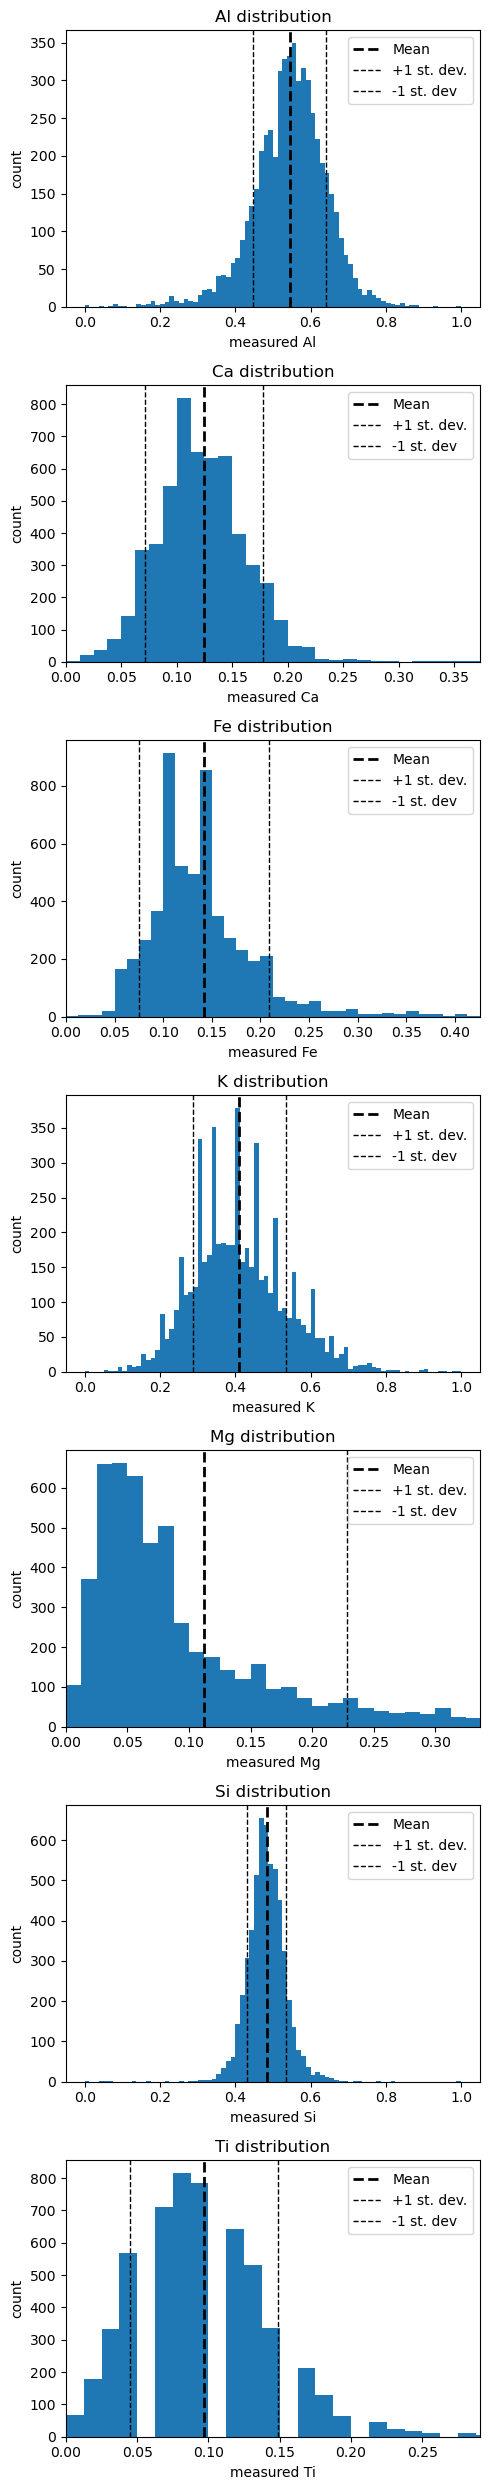

0.015195605197195419


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame and elementNames is a list of element names

# Create a 2D grid for the subplots
num_rows = len(elementNames)
num_cols = 1

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 25))

df = masked_maps['albite_maps']
df_s = df[elementNames]
print(elementNames)

color_values = []
# Loop through each element and create a histogram in the grid
for i, element in enumerate(elementNames):
    # remove the zeros
    df_c = df_s.map(lambda x: max(0, x)).round(0)
    df_f = df_c[(df[elementNames] != 0).any(axis=1)]
    scaler = MinMaxScaler()

    # Fit and transform the data
    df_normalized = pd.DataFrame(scaler.fit_transform(df_f[elementNames]), columns=df_f.columns)

    map = np.asarray(df_normalized[element])
    
    # get mean and st dev
    mean_value = np.mean(map)
    std_dev = np.std(map)

    variance = np.var(map)
    color_value = variance
    color_values.append(color_value)
    
    if mean_value < 0.2:
        xlim_lower = 0  # Adjust as needed
        xlim_upper = mean_value + mean_value * 2  # Adjust as needed
        axes[i].set_xlim(xlim_lower, xlim_upper)

    # Plot the histogram in the specified subplot
    axes[i].hist(map, bins=80)
    axes[i].set_title(f'{element} distribution')
    axes[i].set_xlabel(f'measured {element}')
    axes[i].set_ylabel('count')
    axes[i].axvline(mean_value, color='black', linestyle='dashed', linewidth=2, label='Mean')
    axes[i].axvline(mean_value + std_dev, color='black', linestyle='dashed', linewidth=1, label='+1 st. dev.')
    axes[i].axvline(mean_value - std_dev, color='black', linestyle='dashed', linewidth=1, label='-1 st. dev')
    axes[i].legend()

   

    
    #print(f'Total number of sample points for {element}: {len(map)}')
#fig.suptitle(f'Distribution of normalized elemental frequencies of pixels labelled {this_mineral}', fontsize=16, pad=0.2)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()
print(np.max(color_values))

In [ ]:
datafile.close()
filepath = './Aikin_Data/78.7-10-1_Hot_data.h5'
with h5py.File(filepath, 'r') as datafile:
    print(datafile.keys())
    datagroup = datafile['masked_maps']
    print(datagroup.keys())
    iteration = 0

    dataset = datagroup['mineral_labels']
    map = dataset['mineral_labels']
    hist, bins, _ = plt.hist(map, 8)
    plt.title('Distribution of labels in training dataset')
    plt.xlabel('Mineral labels')
    plt.ylabel('count')
    plt.legend()
    labels = ['None', 'albite mask', 'biotite mask', 'garnet mask', 'kspar mask', 'quartz mask', 'sericite mask', 'muscovite mask','']
    plt.xticks(bins, labels, rotation=45, ha='center')
    plt.show()

print(nunique())

datafile.close()

# oops! looks like albite and biotite and garnet are switched around. fix this!

<KeysViewHDF5 ['RAW', 'binary_masks', 'masked_maps']>
<KeysViewHDF5 ['albite_maps', 'biotite_maps', 'garnet_maps', 'kspar_maps', 'muscovite_maps', 'quartz_maps', 'sericite_maps']>


KeyError: "Unable to synchronously open object (object 'mineral_labels' doesn't exist)"

In [ ]:
df_s = df[elementNames]
df_s.head()

# remove the zeros
df_c = df_s.map(lambda x: max(0, x)).round(0)
df_f = df_c[(df[elementNames] != 0).any(axis=1)]
scaler = MinMaxScaler()

# Fit and transform the data
df_normalized = pd.DataFrame(scaler.fit_transform(df_f[elementNames]), columns=df_f.columns)

series_names = elementNames

# List of series names for which you want to create countplots
series_names = elementNames

# Create a countplot for each series with different hues
for series_name in series_names:
    sns.countplot(data=df_normalized.melt(value_name=series_name), x=series_name, hue='variable', palette='viridis')

plt.legend(title='Series Names')
plt.xlabel('Normalized Value')
plt.ylabel('Count')
plt.title('Count Plot for Each Series')
plt.show()

ValueError: value_name (Al) cannot match an element in the DataFrame columns.

In [ ]:
sns.displot(map, x="", hue=df_f.keys(), kind="kde")



TypeError: Data source must be a DataFrame or Mapping, not <class 'numpy.ndarray'>.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


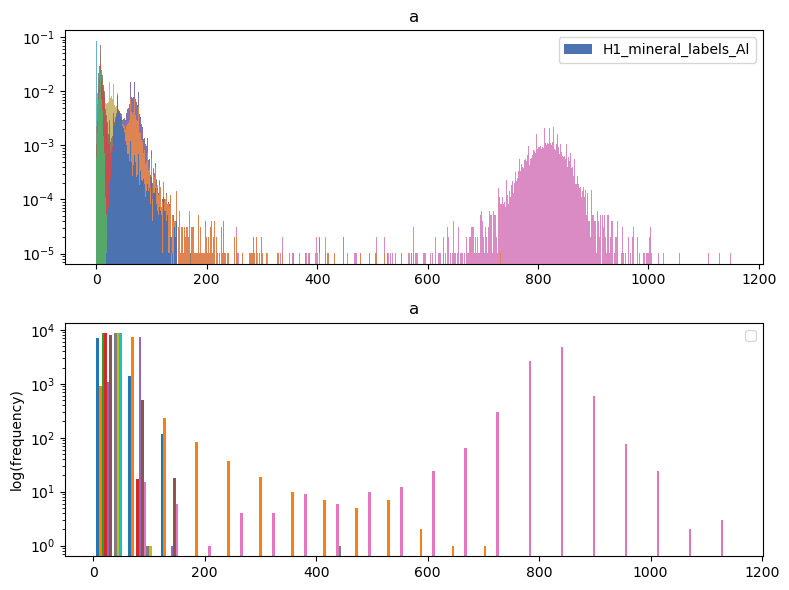

In [ ]:


# create stacked histograms
fig, ((ax0, ax1)) = plt.subplots(nrows=2, ncols=1, figsize=(8,6))

# use Seaborn color palette "Set1"
colors = sns.color_palette("deep")[0:10]

ax0.hist(elements.iloc[:,:], bins=1000, density=True, color=colors, alpha=1, label=elements.iloc[:,series].name, stacked=True)
ax0.set_title('')
ax0.set_yscale('log')
ax0.legend()
ax0.set_title('a')
ax0.set_xlabel('')
ax0.set_ylabel('')
ax0.legend(prop={'size': 10})

# Make a multiple-histogram of data-sets with different length.
ax1.hist(elements.iloc[:,:], bins=20, histtype='bar')
ax1.set_title('different sample sizes')
ax1.set_yscale('log')
ax1.legend()
ax1.set_title('a')
ax1.set_xlabel('')
ax1.set_ylabel('log(frequency)')
ax1.legend(prop={'size': 10})
fig.tight_layout()
plt.show()



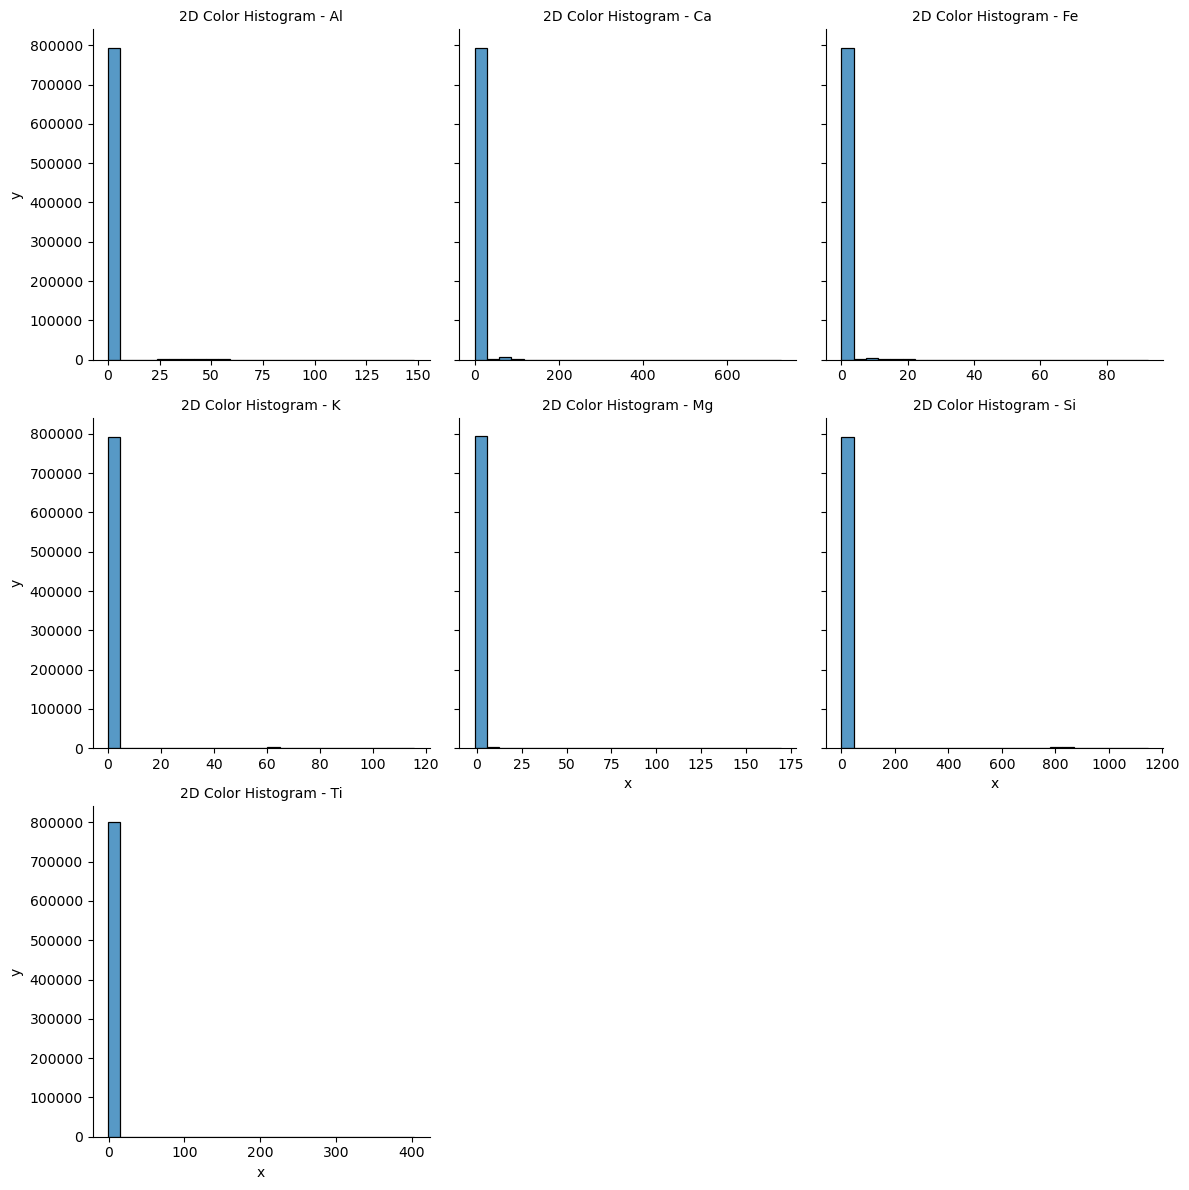

In [ ]:
# Use Seaborn color palette "viridis"
colors = sns.color_palette("viridis")

# Create a FacetGrid for 2D histograms
g = sns.FacetGrid(elements.melt(), col='variable', col_wrap=3, height=4, sharex=False)
g.map(sns.histplot, 'value', bins=25)
# Set axis labels and plot title
g.set_axis_labels('x', 'y')
g.set_titles('2D Color Histogram - {col_name}')

# Add colorbar
#g.fig.colorbar(g.axes[0].collections[0], ax=g.axes, location='right', pad=0.02)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# add confidence intervals

AttributeError: Rectangle.set() got an unexpected keyword argument 'log_scale'

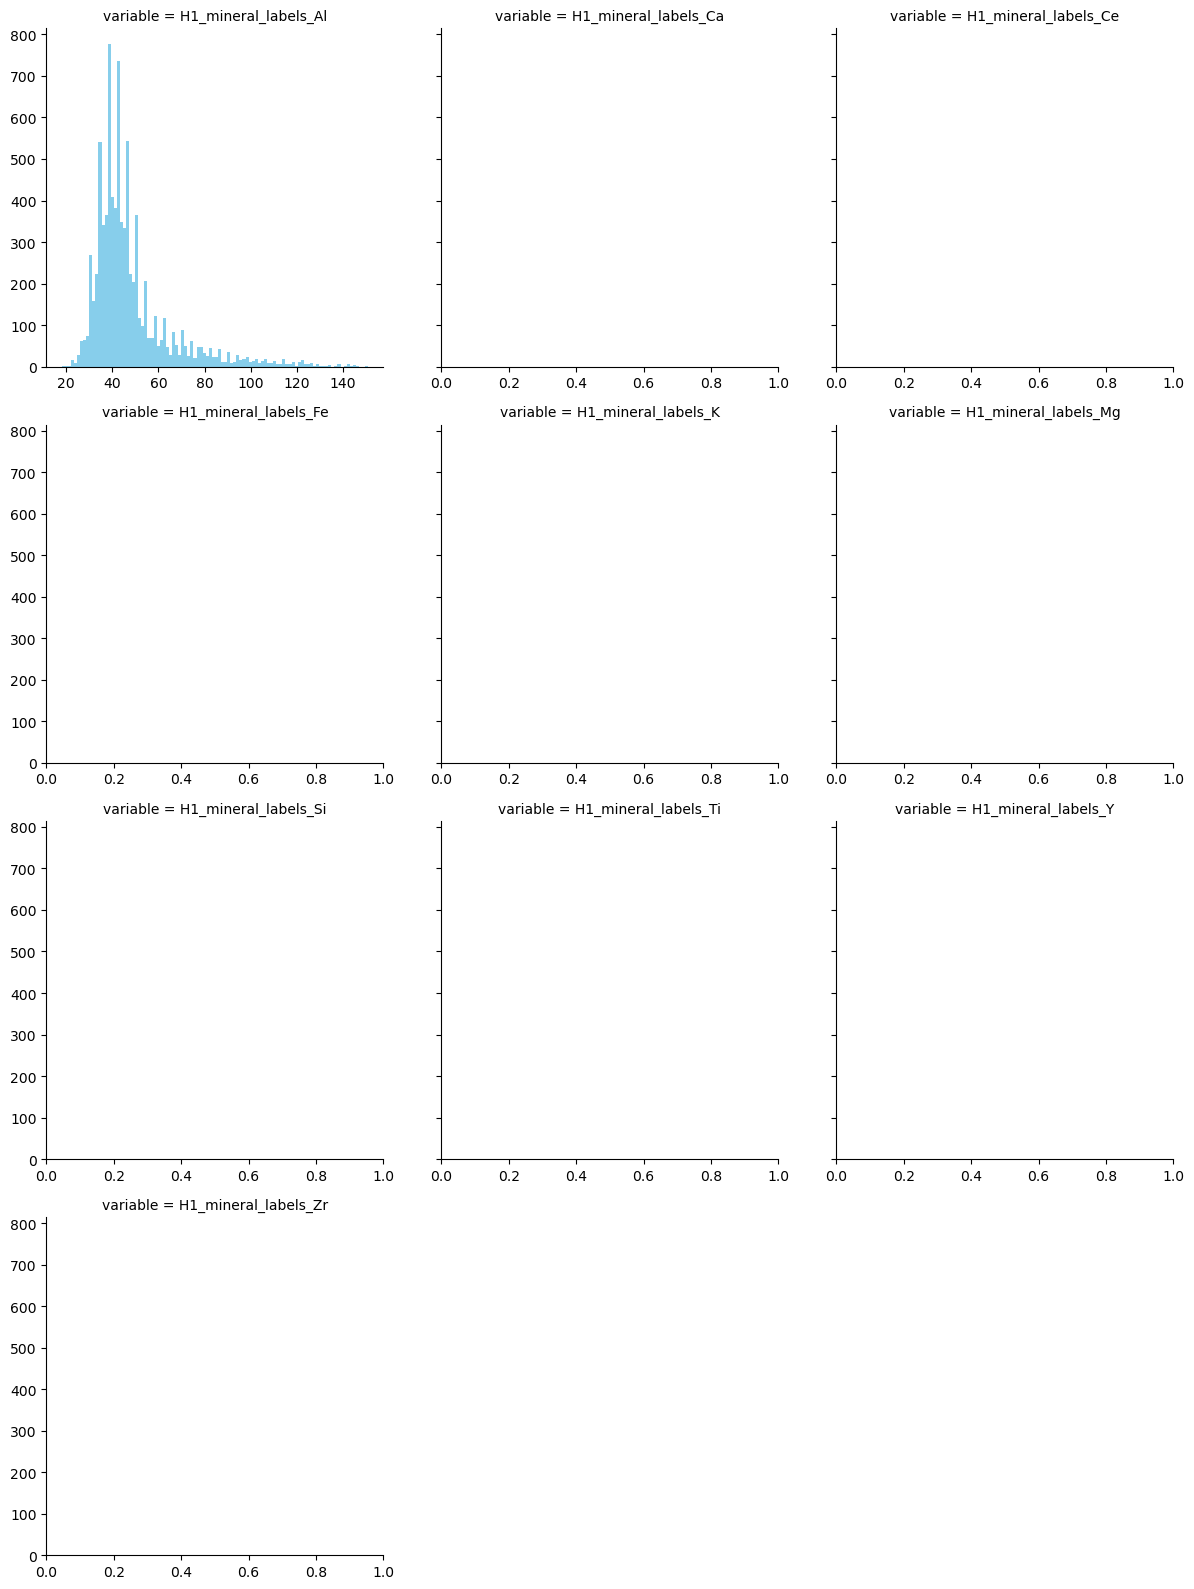

In [ ]:
# Create a FacetGrid of histograms for each series
g = sns.FacetGrid(elements.melt(value_vars=elements.columns), col='variable', col_wrap=3, height=4, sharex=False)
g.map(plt.hist, 'value', bins=100, color='skyblue', log_scale=(False, True))

# Set axis labels and plot title
g.set_axis_labels('Value', 'Frequency')
g.fig.suptitle('Histograms of Variables', y=1.02)

# Show the plot

plt.show()

### 5. Attempt other visualizations


#### Principal Component Analysis

Based on MLGeo-Book's PCA test.


In [ ]:
# PCA

# Import useful modules
import requests, zipfile, io, gzip, glob, os

from sklearn.decomposition import PCA
from sklearn import datasets
import sklearn
from matplotlib import cm
import numpy.linalg as ln


In [ ]:
# Feature selection via parameter exploration

# Heatmap functions
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


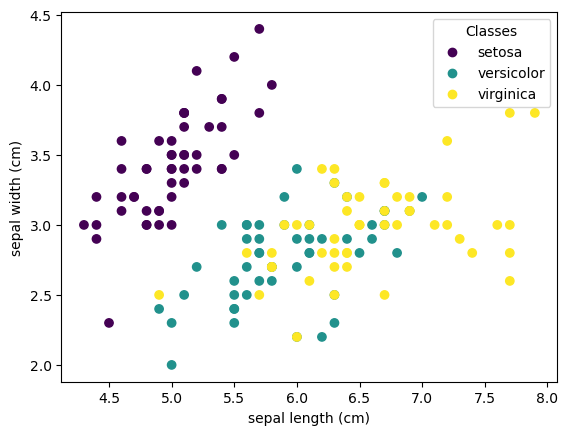

In [ ]:
# Let's load in the iris dataset
iris = datasets.load_iris()

# Convert iris to a pandas dataframe...
irisDF = pd.DataFrame(data=iris.data,  
                  columns=iris.feature_names)

# Now, plot up sepal length vs width, color-coded by target (or species)

scatter = plt.scatter(irisDF['sepal length (cm)'], irisDF['sepal width (cm)'], c=iris.target)
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend(scatter.legend_elements()[0], iris.target_names, title="Classes")
irisDF.head()


In [ ]:
label_df = masked_maps[mineralKeys[-1]]
label_df.head()

,x_coords,y_coords,Al,Ca,Ce,Fe,K,Mg,Si,Ti,Y,Zr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0
3,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
4,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(mineralMaps)

this_mineral = mineralMaps[2]

NameError: name 'mineralMaps' is not defined

In [7]:

# Create a 2D grid for the subplots
num_rows = len(elementNames)
num_cols = len(elementNames)

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Now, plot scatter plots for each pair of elements
for i in range(num_rows):
    for j in range(num_cols):
        this_element = elementNames[i]
        that_element = elementNames[j]
        this_df = masked_maps[this_mineral]
        this_df_c = this_df.map(lambda x: max(0, x))
        this_df_f = this_df_c[(df[elementNames] != 0).any(axis=1)]

        X = this_df_f[this_element]
        Y = this_df_f[that_element]
        cov = sum((X - np.mean(X)) * (Y - np.mean(Y))) / (len(X) - 1)
        color_value = cov/0.0976914658203131 # color_values.max()
        print(color_value)
        #print(this_df_f[this_element], this_df_f[that_element])
        # Use scatter plot]
        axes[i, j].scatter(this_df_f[this_element], this_df_f[that_element], alpha=0.5, color=plt.cm.plasma(color_value))
        axes[i, j].set_xlabel(f'{this_element}')
        axes[i, j].set_ylabel(f'{that_element}')

plt.suptitle(f'Covariance of element frequencies in {this_mineral[:-5]}. Lighter colors indicate high covariance.', size=20)
# Adjust layout and show the plot
plt.tight_layout()
plt.show()



NameError: name 'elementNames' is not defined

In [ ]:
# Now, how might we reduce these dimensions? 
# One way is by looking at how variables are correlated
# Calculate the correlation coefficients for all variables
allCorr = df.corr()

im, _ = heatmap(allCorr, df, df,
                cmap="PuOr", vmin=-1, vmax=1,
                cbarlabel="correlation coeff.")

annotate_heatmap(im, size=7)

plt.tight_layout()
plt.show()


NameError: name 'df' is not defined

In [ ]:
this_mineral = mineralMaps[2]
df = masked_maps[this_mineral]

df = masked_maps[this_mineral]

# replace negative numbers with zeros using .map and a lambda function
df_c = df.map(lambda x: max(0, x))

# reduce the number of decimat places
df_f = df_c[(df[elementNames] != 0).any(axis=1)]

print('These are statistical features of ' + this_mineral[:-5])
df_f.describe().round(2)

These are statistical features of garnet


,x_coords,y_coords,Al,Ca,Ce,Fe,K,Mg,Si,Ti,Y,Zr
count,20174.00,20174.00,20174.00,20174.00,20174.00,20174.00,20174.00,20174.00,20174.00,20174.00,20174.00,20174.00
mean,431.21,544.96,293.06,57.92,8.51,134.96,74.44,204.40,422.59,8.85,35.02,0.37
std,137.64,82.69,27.19,9.27,3.52,23.95,16.97,56.80,40.10,7.06,19.56,0.68
min,5.00,414.00,75.15,27.23,0.00,4.48,23.57,0.68,74.45,0.00,4.06,0.00
25%,431.00,486.00,279.15,52.23,5.74,126.48,62.57,172.68,406.45,6.07,30.06,0.00
50%,466.00,532.00,293.15,57.23,8.74,138.48,70.57,201.68,422.45,8.07,34.06,0.00
75%,505.00,574.00,307.15,63.23,10.74,148.48,82.57,226.68,439.45,10.07,39.06,0.68
max,561.00,790.00,415.15,323.23,133.74,268.48,130.57,422.68,752.45,505.07,1618.06,20.68


None of the correlation coefficients are larger than 0.44! This means that this data is still a bit broad.


In [ ]:
allCorr

,x_coords,y_coords,Al_map,Ca_map,Ce_map,Fe_map,K_map,Mg_map,Si_map,Ti_map,Y_map,Zr_map
x_coords,1.000000,-0.042453,-0.426114,0.026885,0.052058,0.079777,-0.180051,0.329294,-0.050549,-0.015021,0.073015,0.004862
y_coords,-0.042453,1.000000,-0.118351,-0.031765,0.015587,-0.034677,-0.085797,0.027288,-0.108790,-0.012319,0.025784,0.008533
Al_map,-0.426114,-0.118351,1.000000,-0.115212,-0.064139,-0.437718,0.124069,-0.377528,0.225736,-0.097953,-0.088133,-0.008761
Ca_map,0.026885,-0.031765,-0.115212,1.000000,-0.001288,0.018887,-0.048394,-0.047456,-0.078147,-0.015898,0.003683,0.000872
Ce_map,0.052058,0.015587,-0.064139,-0.001288,1.000000,0.028221,-0.000242,0.076299,-0.053672,0.057270,0.069330,0.005796
Fe_map,0.079777,-0.034677,-0.437718,0.018887,0.028221,1.000000,0.078227,0.288650,-0.355917,0.116656,0.033053,-0.002060
K_map,-0.180051,-0.085797,0.124069,-0.048394,-0.000242,0.078227,1.000000,0.015435,-0.051802,0.078876,-0.023028,-0.005200
Mg_map,0.329294,0.027288,-0.377528,-0.047456,0.076299,0.288650,0.015435,1.000000,-0.232657,0.117194,0.107036,-0.003959
Si_map,-0.050549,-0.108790,0.225736,-0.078147,-0.053672,-0.355917,-0.051802,-0.232657,1.000000,-0.158969,-0.063039,-0.010391
Ti_map,-0.015021,-0.012319,-0.097953,-0.015898,0.057270,0.116656,0.078876,0.117194,-0.158969,1.000000,0.036609,0.006674


### PCA

based on [AksPython.com](https://www.askpython.com/python/examples/principal-component-analysis-for-image-data).


In [25]:
this_mineral = mineralMaps[2]
this_df = masked_maps[this_mineral]
data = this_df.iloc[:,2:]
data_c = data.map(lambda x: max(0, x))
data_f = data_c[(data != 0).any(axis=1)]
data_centered = data_f - np.mean(data_f)


In [26]:
#Import required modules
from sklearn.decomposition import PCA
 
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(data_centered)
 
converted_data.shape

(20174, 2)

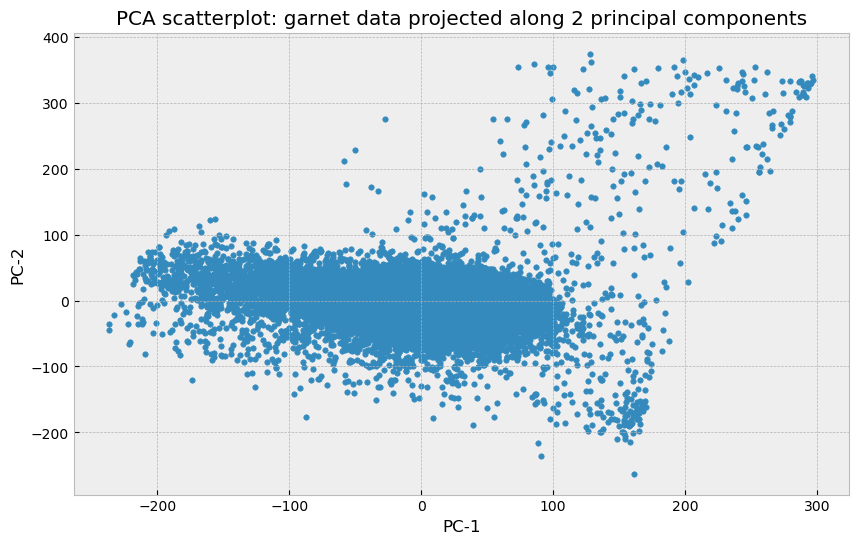

In [27]:
plt.figure(figsize = (10,6))
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title(f'PCA scatterplot: {this_mineral[:-5]} data projected along 2 principal components')
plt.show()

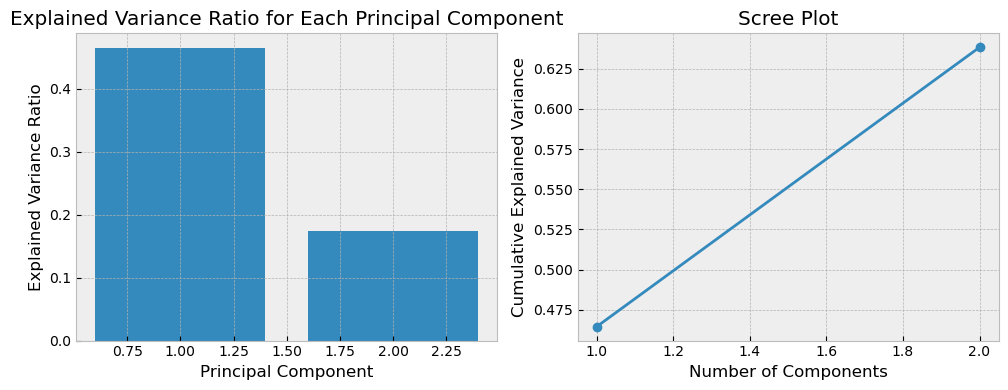

In [19]:

# Fit PCA
pca = PCA(2)  # we need 2 principal components
converted_data = pca.fit_transform(data_centered)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Each Principal Component')

# Plot scree plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.tight_layout()

plt.show()